In [194]:
import numpy as np
#import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import Video
from IPython.display import Audio

In [195]:
def get_interpolated(array, index):
    if not hasattr(array, "__len__"): return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [196]:
def calculate_next_psi(psi, dt, potential):
    n = psi.shape[0]
    
    # potential part
    next_psi = [[psi[i, j] * np.exp(1j * dt * potential[i, j]) for j in range(n)] for i in range(n)]

    next_psi = np.fft.fft2(next_psi)
    
    # time part
    for i in range(n):
        for j in range(n):
            k = 2*np.pi * min(i, n-i)
            l = 2*np.pi * min(j, n-j)
            theta = (k*k + l*l) * dt
            next_psi[i, j] *= np.exp(1j * theta)
    
    next_psi = np.fft.ifft2(next_psi)
    return next_psi

In [197]:
def gaussian(x, y, n, offset, width):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return np.exp(-(x*x + y*y) / (width*width)) + 0j

In [198]:
def parabolar(x, y, n, offset, factor):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return factor * (x*x + y*y) + 0j
    

In [199]:
parabolar(64, 0, 128, [0, 0], 1)

(1+0j)

In [200]:
def circle(rad, radius, offset, n):
    return (radius * np.array([np.cos(rad), np.sin(rad)]) + offset) * n//2 + n//2

In [201]:
np.concatenate(([5], circle(0, 1, 0, 128)), axis=0)

array([  5., 128.,  64.])

In [212]:
n = 128

samplerate = 44100
frequency = 110
interest_radius = 0.6
interest_center = [0, 0]

psi_init = np.array([[gaussian(x, y, n, offset=[-0.6, 0.0], width=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[parabolar(x, y, n, offset=[0,0], factor=10000) for x in range(n)] for y in range(n)])

# barrier
double_slit = [(-5, -2), (2, 5)]
single_slit = [(-2, 2)]
slits = single_slit

barrier_height = 1e20
barrier = [barrier_height] * n
for s in slits:
    barrier[n//2+s[0]:n//2+s[1]] = [0] * (s[1]-s[0])
for i in range(n):
    potential[:, n//2-1] += barrier

In [213]:
potential

array([[20000.        +0.j, 19689.94140625+0.j, 19384.765625  +0.j, ...,
        19084.47265625+0.j, 19384.765625  +0.j, 19689.94140625+0.j],
       [19689.94140625+0.j, 19379.8828125 +0.j, 19074.70703125+0.j, ...,
        18774.4140625 +0.j, 19074.70703125+0.j, 19379.8828125 +0.j],
       [19384.765625  +0.j, 19074.70703125+0.j, 18769.53125   +0.j, ...,
        18469.23828125+0.j, 18769.53125   +0.j, 19074.70703125+0.j],
       ...,
       [19084.47265625+0.j, 18774.4140625 +0.j, 18469.23828125+0.j, ...,
        18168.9453125 +0.j, 18469.23828125+0.j, 18774.4140625 +0.j],
       [19384.765625  +0.j, 19074.70703125+0.j, 18769.53125   +0.j, ...,
        18469.23828125+0.j, 18769.53125   +0.j, 19074.70703125+0.j],
       [19689.94140625+0.j, 19379.8828125 +0.j, 19074.70703125+0.j, ...,
        18774.4140625 +0.j, 19074.70703125+0.j, 19379.8828125 +0.j]])

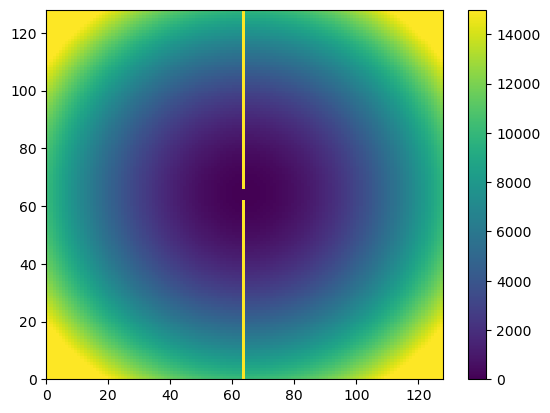

In [214]:
#plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
plt.pcolormesh(np.abs(potential), vmax=15000)
plt.colorbar()
plt.show()

In [218]:
frame_amount = 1000

psi = psi_init
frames = [psi]

for i in range(frame_amount):
    for timestep in range(10):
        psi = calculate_next_psi(psi, 0.00002, potential)
    print("\r" + str(i) + " " if i % 10 == 0 else "", end="")
    frames.append(psi)

print("\nFinished simulation")

990 
Finished simulation


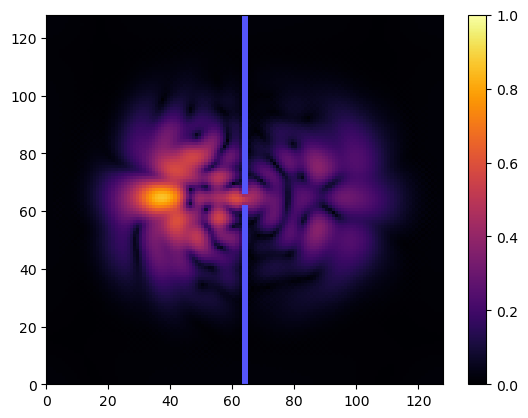

In [219]:
# FuncAnimation
fig, ax = plt.subplots()
cax = ax.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)

rect = patches.Rectangle((n//2-1, 0), 2, n//2-2, linewidth=0, edgecolor='r', facecolor='#5555fa')
rect2 = patches.Rectangle((n//2-1, n//2+2), 2, n//2-2, linewidth=0, edgecolor='r', facecolor='#5555fa')
ax.add_patch(rect)
ax.add_patch(rect2)

fig.colorbar(cax)

def animate(i):
    cax.set_array(pow(np.abs(frames[i]), 2.0/3.0).flatten())

anim = animation.FuncAnimation(fig, animate, frames=len(frames))
anim.save('visual.mp4', fps=20, dpi=150, bitrate=4000)
plt.show()

In [ ]:
import os
os.system(' '.join(['ffmpeg', '-c:v', 'h264_cuvid', '-i', 'visual.mp4', '-c:v', 'h264_nvenc', 'visual_tmp.mp4']))

In [220]:
# Sonification
rad_per_sample = 2 * np.pi * frequency / samplerate
audio = [np.square(np.abs(get_interpolated(frames, np.concatenate((np.array([i * fps/samplerate]), circle(rad_per_sample * i, interest_radius, interest_center, n)), axis=0)))) for i in range(samplerate*duration)]

print("Finished sonicifaction")

Finished sonicifaction


In [222]:
Audio(audio, rate=samplerate)

In [223]:
import pickle

In [229]:
f = open("frames_save_1000_10_0.00002.pckl", "wb")
pickle.dump(frames, f)
f.close()

In [225]:
f = open('audio_save.pckl', 'rb')
obj = pickle.load(f)
f.close()

In [228]:
Audio(obj, rate=samplerate)